<a href="https://colab.research.google.com/github/shunzh/llm.ipynb/blob/main/llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a Decoder-Only Transformer from Scratch

We implement a decoder-only Transformer architecture with minimum dependencies. This notebook is organized as follows.

- Architecture (with single head self-attention)
- Model Training and Greedy Decoding
- Other features **(WIP)**
  - Sampling algorithms
  - KV cache
  - Multi-head self-attention
  - FlashAttention / memory-efficient attention

We first import the necessary libraries and set the random seed.

In [ ]:
import math
import torch
import torch.nn as nn

# Set random seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Architecture

We first define a model config object with default parameter values.


In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
    # The size of hidden state in transformer, also called d_model
    hidden_size: int = 512
    # The size of hidden state in MLP in the decoder block
    ff_hidden_size: int = 4 * 512
    # The number of decoder blocks
    num_hidden_layers: int = 2
    # Dropout rates for all modules that need dropout
    dropout_rate: float = 0.1
    vocab_size: int = 10000
    max_seq_len: int = 128

config = Config()

### Decoder Block

The decoder block is the core of the transformer. It has four modules inside (where the LayerNorm appears twice):

```
Input: x (batch_size, seq_len, hidden_size)
        │
        ▼
+-------------------+
|   LayerNorm       |
+-------------------+
        │
        ▼
+-------------------+
|  Self-Attention   |  (single head, with causal mask)
+-------------------+
        │
        ▼
+-------------------+
|   LayerNorm       |
+-------------------+
        │
        ▼
+-------------------+
|      MLP          |  (Linear → GELU → Linear)
+-------------------+
        │
        ▼
     Output x
```

Let's define these modules.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-5):
        super().__init__()

        self.gamma = nn.Parameter(torch.ones(hidden_size)) # (hidden_size,)
        self.beta = nn.Parameter(torch.zeros(hidden_size)) # (hidden_size,)
        self.eps = eps

    def forward(self, x):
        # x: (batch_size, seq_len, hidden_size)
        mean = x.mean(dim=-1, keepdim=True) # (batch_size, seq_len, 1)
        std = x.std(dim=-1, keepdim=True) # (batch_size, seq_len, 1)
        return (x - mean) / (std + self.eps) * self.gamma + self.beta # (batch_size, seq_len, hidden_size)


# Test layer norm
layer_norm = LayerNorm(config.hidden_size)
x = torch.randn(2, 3, config.hidden_size)
layer_norm_output = layer_norm(x)
print("The size of layer norm output is (batch_size, seq_len, hidden_size):", layer_norm_output.shape)

The size of layer norm output is (batch_size, seq_len, hidden_size): torch.Size([2, 3, 512])


In [ ]:
class SingleHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, dropout_rate=0.1):
        super().__init__()

        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate

        # Attention: hiddent state to query, key, value
        self.c_attn = nn.Linear(hidden_size, 3 * hidden_size)
        # Output projection
        self.c_proj = nn.Linear(hidden_size, hidden_size)

        # Dropouts
        self.attn_dropout = nn.Dropout(dropout_rate)
        self.proj_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, return_attn=False):
        # x: (batch_size, seq_len, hidden_size)
        batch_size, seq_len, hidden_size_in_data = x.shape
        assert self.hidden_size == hidden_size_in_data, f"Mismatch betwee hidden_size in config {self.hidden_size} and hidden_size in data {hidden_size_in_data}"

        c_attn_output = self.c_attn(x) # (batch_size, seq_len, 3 * hidden_size)

        # Split into query, key, and value
        q, k, v = c_attn_output.split(self.hidden_size, dim=-1)

        # Compute attention scores
        # q: (.., seq_len, hidden_size)
        # k.transpose(-2, -1): (.., hidden_size, seq_len)
        attn = (q @ k.transpose(-2, -1)) / (math.sqrt(self.hidden_size)) # (batch_size, seq_len, seq_len)

        # Apply causal mask
        mask = torch.tril(torch.ones(1, seq_len, seq_len)).to(attn.device) # (1, seq_len, seq_len)
        attn = attn.masked_fill(mask == 0, float('-inf'))

        # Softmax
        attn = torch.softmax(attn, dim=-1)

        # Dropout attention
        attn = self.attn_dropout(attn)

        # Attention output
        # attn: (.., seq_len, seq_len)
        # v: (.., seq_len, d_head)
        attn_output = attn @ v # (batch_size, seq_len, d_head)

        # Final projection
        proj_output = self.c_proj(attn_output)
        proj_output = self.proj_dropout(proj_output) # (batch_size, seq_len, d_head)

        if return_attn:
            return proj_output, attn
        else:
            return proj_output


# Test
x = torch.randn(2, 3, config.hidden_size)
self_attention = SingleHeadSelfAttention(config.hidden_size)
output, attn = self_attention(x, return_attn=True)
print("The attention matrix is: (Note that due to drop out, the values are scaled to (1 - dropout_rate))\n", attn)
print("The shape of output is (batch_size, seq_len, d_head):", output.shape)

The attention matrix is: (Note that due to drop out, the values are scaled to (1 - dropout_rate))
 tensor([[[1.1111, 0.0000, 0.0000],
         [0.4300, 0.6812, 0.0000],
         [0.3499, 0.4116, 0.3497]],

        [[1.1111, 0.0000, 0.0000],
         [0.7287, 0.3824, 0.0000],
         [0.3532, 0.2315, 0.5264]]], grad_fn=<MulBackward0>)
The shape of output is (batch_size, seq_len, d_head): torch.Size([2, 3, 512])


In [ ]:
class MLP(nn.Module):
    def __init__(self, hidden_size, ff_hidden_size, dropout_rate=0.1):
        super().__init__()

        self.hidden_size = hidden_size
        self.ff_hidden_size = ff_hidden_size

        self.c_fc = nn.Linear(self.hidden_size, self.ff_hidden_size)
        self.act = nn.GELU() # Or other activation functions
        self.c_proj = nn.Linear(self.ff_hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x: (batch_size, seq_len, hidden_size)
        x = self.c_fc(x) # (batch_size, seq_len, ff_hidden_size)
        x = self.act(x) # (batch_size, seq_len, ff_hidden_size)
        x = self.c_proj(x) # (batch_size, seq_len, hidden_size)
        x = self.dropout(x)
        return x


# Test MLP
x = torch.randn(2, 3, config.hidden_size)
mlp = MLP(config.hidden_size, config.ff_hidden_size)
output = mlp(x)
print("Output shape:", output.shape)

Output shape: torch.Size([2, 3, 512])


With all the pieces defined above, we're ready to define the decoder block.

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, hidden_size, ff_hidden_size, dropout_rate=0.1):
        super().__init__()
        self.ln_1 = LayerNorm(hidden_size)
        self.attn = SingleHeadSelfAttention(hidden_size, dropout_rate)
        self.ln_2 = LayerNorm(hidden_size)
        self.mlp = MLP(hidden_size, ff_hidden_size, dropout_rate)

    def forward(self, x):
        # x: (batch_size, seq_len, hidden_size)
        # Layer norm 1
        x = self.ln_1(x)
        # Self attention + residual
        x = x + self.attn(x)
        # Layer norm 2
        x = self.ln_2(x)
        # MLP + residual
        x = x + self.mlp(x)

        return x


# Test Decoder
x = torch.randn(2, 3, config.hidden_size)
decoder = DecoderBlock(config.hidden_size, config.ff_hidden_size)
x = decoder(x)
print(x.shape)

torch.Size([2, 3, 512])


### The Complete Transformer Model

With the Decoder block defined above, we're ready to define the complete Transformer architecture.

```
Input: input_ids (batch_size, seq_len)
        │
        ▼
+------------------------+
|  Token Embedding       |
|  Position Embedding    |
+------------------------+
        │
        ▼
+------------------------+
|   DecoderBlock × N     |  (defined in the previous section)
+------------------------+
        │
        ▼
+------------------------+
|   Final LayerNorm      |
+------------------------+
        │
        ▼
+------------------------+
|  Linear (Language Head)|
+------------------------+
        │
        ▼
Output: logits (batch_size, seq_len, vocab_size)
```


In [ ]:
class Transformer(nn.Module):
    def __init__(
        self,
        hidden_size,
        ff_hidden_size,
        vocab_size,
        max_seq_len,
        num_hidden_layers,
        dropout_rate=0.1
    ):
        super().__init__()

        self.token_embed = nn.Embedding(vocab_size, hidden_size)
        self.position_embed = nn.Embedding(max_seq_len, hidden_size)
        self.embed_dropout = nn.Dropout(dropout_rate)

        self.hidden_layers = nn.ModuleList([DecoderBlock(hidden_size, ff_hidden_size, dropout_rate) for _ in range(num_hidden_layers)])
        # The final layer norm
        self.ln_f = nn.LayerNorm(hidden_size)

        # The final language head, which maps the last hidden state to logits
        self.language_head = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_ids):
        # input_ids: (batch_size, seq_len)
        batch_size, seq_len = input_ids.shape

        # Create position ids (0, 1, 2, ..., seq_len-1)
        position_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0) # (1, seq_len)

        # Embed tokens and positions, apply dropout
        x = self.token_embed(input_ids) + self.position_embed(position_ids)
        x = self.embed_dropout(x)

        # Pass through decoder blocks
        for layer in self.hidden_layers:
            x = layer(x)

        # Final layer norm
        x = self.ln_f(x)

        # Project to vocabulary
        logits = self.language_head(x) # (batch_size, seq_len, vocab_size)

        return logits


# Test Transformer
input_ids = torch.randint(0, config.vocab_size, (2, 3))

model = Transformer(
    hidden_size=config.hidden_size,
    ff_hidden_size=config.ff_hidden_size,
    vocab_size=config.vocab_size,
    max_seq_len=config.max_seq_len,
    num_hidden_layers=config.num_hidden_layers,
    dropout_rate=config.dropout_rate,
)
print("Our Transformer model:\n", model)

logits = model(input_ids)
print("Logits shape:", logits.shape)

Our Transformer model:
 Transformer(
  (token_embed): Embedding(10000, 512)
  (position_embed): Embedding(128, 512)
  (embed_dropout): Dropout(p=0.1, inplace=False)
  (hidden_layers): ModuleList(
    (0-1): 2 x DecoderBlock(
      (ln_1): LayerNorm()
      (attn): SingleHeadSelfAttention(
        (c_attn): Linear(in_features=512, out_features=1536, bias=True)
        (c_proj): Linear(in_features=512, out_features=512, bias=True)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (proj_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm()
      (mlp): MLP(
        (c_fc): Linear(in_features=512, out_features=2048, bias=True)
        (act): GELU(approximate='none')
        (c_proj): Linear(in_features=2048, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (language_head): Linear(in_features=512, out_features=10000, bias=True)
)
Logits shape: torc

## Model Training and Inference

Now we are ready to train the Transformer architecture we defined above.

Let's first load the training data, tokenize them using the GPT2 tokenizer, and create a dataloader for training.

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

# Load tiny_shakespeare dataset
dataset = load_dataset("karpathy/tiny_shakespeare", split="train")
val_dataset = load_dataset("karpathy/tiny_shakespeare", split="validation")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Update config
config.vocab_size = tokenizer.vocab_size

# Tokenize entire corpus
def tokenize(example):
    return tokenizer(example["text"])

tokenized = dataset.map(tokenize, batched=True, remove_columns=["text"])
val_tokenized = val_dataset.map(tokenize, batched=True, remove_columns=["text"])

# Flatten input_ids across all examples
# (note that tiny_shakespeare only contains one long example)
all_tokens = sum(tokenized["input_ids"], [])  # list of ints
all_val_tokens = sum(val_tokenized["input_ids"], [])
# Use a smaller validation set
all_val_tokens = all_val_tokens[:2000]


class TokenDataset(Dataset):
    def __init__(self, tokens, seq_len):
        self.tokens = tokens
        self.seq_len = seq_len

    def __len__(self):
        return len(self.tokens) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.tokens[idx : idx + self.seq_len], dtype=torch.long)
        y = torch.tensor(self.tokens[idx + 1 : idx + self.seq_len + 1], dtype=torch.long)
        return x, y

seq_len = 128
dataset = TokenDataset(all_tokens, seq_len)
val_dataset = TokenDataset(all_val_tokens, seq_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True, pin_memory=True)

print("Number of batches in training set:", len(dataloader))
print("Number of batches in validation set:", len(val_dataloader))

We're now ready to run the training loop.

It will stop when the validation loss keeps going up.
You may kill the following cell at any point. The checkpoint with the minimum validation loss will be saved and can be used for inference in the next cell.

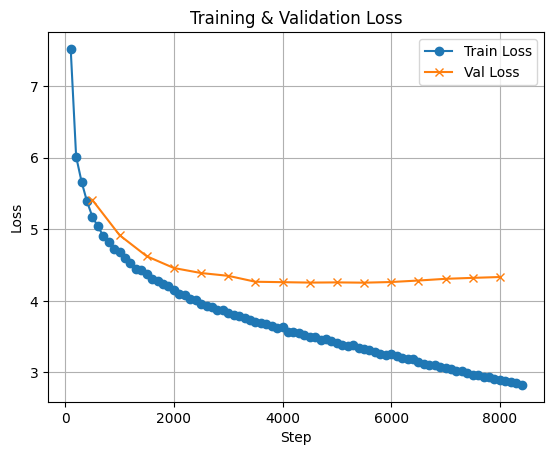

Epoch 0:  45%|████▌     | 8499/18864 [22:25<27:21,  6.32it/s]

Early stopping. No improvement in the last 5 steps.

Training complete.


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


def refresh_plot(train_steps, train_losses, val_steps, val_losses):
    clear_output(wait=True)
    plt.clf()
    plt.plot(train_steps, train_losses, label="Train Loss", marker="o")
    plt.plot(val_steps, val_losses, label="Val Loss", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    display(plt.gcf())
    plt.close()


def train(
    model,
    dataloader,
    val_dataloader,
    optimizer,
    criterion,
    epochs,
    device=torch.device("cpu"),
    log_interval=100,
    eval_interval=500,
    patience=5,
):
    model.train()
    step = 0
    batch_losses = []
    train_loss_history = []
    val_loss_history = []
    train_step_history = []
    val_step_history = []

    steps_since_best_ckpt = 0
    plt.figure(figsize=(8, 5))

    for epoch in range(epochs):
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch}"):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            logits = model(x)
            loss = criterion(logits.view(-1, logits.shape[-1]), y.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            step += 1
            refresh = False

            if step % log_interval == 0:
                avg_loss = sum(batch_losses) / len(batch_losses)
                train_loss_history.append(avg_loss)
                train_step_history.append(step)
                batch_losses = []
                refresh = True

            if step % eval_interval == 0:
                model.eval()
                val_loss = 0
                count = 0
                with torch.no_grad():
                    for vx, vy in val_dataloader:
                        vx = vx.to(device, non_blocking=True)
                        vy = vy.to(device, non_blocking=True)
                        logits = model(vx)
                        loss = criterion(logits.view(-1, logits.shape[-1]), vy.view(-1))
                        val_loss += loss.item()
                        count += 1
                val_loss /= count

                if len(val_loss_history) == 0 or val_loss < min(val_loss_history):
                    # This is the best model on validation set so far
                    steps_since_best_ckpt = 0

                    # Save the model weights
                    torch.save(model.state_dict(), "/content/model.pth")
                else:
                    # This is worse than the best model on validation set
                    steps_since_best_ckpt += 1

                    if steps_since_best_ckpt > patience:
                        print(f"Early stopping. No improvement in the last {patience} steps.")
                        break

                val_loss_history.append(val_loss)
                val_step_history.append(step)

                model.train()
                refresh = True

            if refresh:
                refresh_plot(train_step_history, train_loss_history, val_step_history, val_loss_history)

    print("Training complete.")


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

# Initialize model
model = Transformer(
    hidden_size=config.hidden_size,
    ff_hidden_size=config.ff_hidden_size,
    vocab_size=config.vocab_size,
    max_seq_len=config.max_seq_len,
    num_hidden_layers=config.num_hidden_layers,
    dropout_rate=config.dropout_rate,
).to(device)

# Optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

train(
    model,
    dataloader,
    val_dataloader,
    optimizer,
    criterion,
    epochs=1,
    device=device,
    log_interval=100,
    eval_interval=500,
    patience=5,
)

### Greedy Decoding

Let's run greedy decoding using the trained model.

In [ ]:
def greedy_decode(model, input_ids, max_len, device=torch.device("cpu")):
    model.eval()
    # input_ids: (batch_size, seq_len)
    input_ids = input_ids.to(device)

    for _ in range(max_len - input_ids.size(1)):
        logits = model(input_ids) # (batch_size, seq_len, vocab_size)
        next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True) # (batch_size, 1)
        input_ids = torch.cat((input_ids, next_token), dim=-1)

    return input_ids


#  The training cell above may have been killed. So redefine these variables here.
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

# Initialize model
model = Transformer(
    hidden_size=config.hidden_size,
    ff_hidden_size=config.ff_hidden_size,
    vocab_size=config.vocab_size,
    max_seq_len=config.max_seq_len,
    num_hidden_layers=config.num_hidden_layers,
    dropout_rate=config.dropout_rate,
).to(device)

# Load trained model
model.load_state_dict(torch.load("/content/model.pth", map_location=device))

# Use an empty prompt
input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)

# Run greedy decoding
output_ids = greedy_decode(model, input_ids, max_len=128, device=device)
generated_text = tokenizer.decode(output_ids[0].tolist(), skip_special_tokens=True)

print("==== Model output ====")
print(generated_text)

Using device cuda
==== Model output ====
,
And, by the Duke of York,
And all the world goes,
And, with the rest of York,
And, with the Duke of York,
And all the rest,
And that the king's king,
And that the king's king, to the crown,
And the king, to the Duke of York,
And, by the Duke of York,
And made the king's king, and the king's king,
And that the king's king,
And that the king's king,
And that the king was the king's king,
And that the king


## Other Features

TODO Not finished

### Multi-Head Self Attention

Multi-head is slightly more complicated as we need to divide the `c_attn` output into different heads.

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout_rate=0.1):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_heads = num_heads
        # Find the embedding size for each head
        assert self.hidden_size % self.num_heads == 0
        self.d_head = self.hidden_size // self.num_heads
        self.dropout_rate = dropout_rate

        # Attention: hiddent state to query, key, value
        self.c_attn = nn.Linear(hidden_size, 3 * hidden_size)
        # Output projection
        self.c_proj = nn.Linear(hidden_size, hidden_size)

        # Dropouts
        self.attn_dropout = nn.Dropout(dropout_rate)
        self.proj_dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Project to QKV and split
        qkv = self.c_attn(x)  # (batch_size, seq_len, 3 * hidden_size)
        q, k, v = qkv.chunk(3, dim=-1)

        # Reshape and transpose for multi-head attention
        q = q.view(batch_size, seq_len, self.num_heads, self.d_head).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.d_head).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.d_head).transpose(1, 2)

        # Attention scores
        attn_scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_head)

        # Causal mask
        mask = torch.tril(torch.ones(seq_len, seq_len, device=x.device)).unsqueeze(0).unsqueeze(0)
        attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        # Softmax and dropout
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        # Weighted sum of values
        attn_output = attn_weights @ v  # (batch_size, num_heads, seq_len, d_head)

        # Concatenate heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_size)

        # Final projection + dropout
        out = self.c_proj(attn_output)
        out = self.proj_dropout(out)

        return out

## Other Useful Resources

- We use [Hugging Face's implementation of GPT2](https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py) as a reference.
- [The Illustrated GPT-2](https://jalammar.github.io/illustrated-gpt2/): A blog on illustrating GPT2.
- [llm.c](https://github.com/karpathy/llm.c): Implementation of LLM from scratch in C.
- Original paper:
    - Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems 30 (2017).